In [1]:
import numpy as np
from importlib import reload
import sys
sys.path.append('../scripts')
import numerics
import matplotlib.pyplot as plt
import time
import style

import matplotlib
from os.path import exists
from zipfile import BadZipFile
from scipy.stats import mode

In [3]:
"""
Load data
"""

all_D = np.zeros((40, 40, 5, 10, 2500, 2, 6))
all_S = np.zeros((40, 40, 5, 10, 2500, 2, 2))
w_re_vals = None
w_im_vals = None
for i in range(200):
    if i % 10 == 0:
        print(i)
    fname = "/media/davidclark/DATA/SubspaceData/lc_results_v4/results_{}.npz".format(i)
    if exists(fname):
        try:
            data = np.load(fname)
            if w_re_vals is None:
                w_re_vals = data['w_re_vals']
                w_im_vals = data['w_im_vals']
            w_re, superrun_idx = data['param_vals'][int(data['task_idx'])]
            #print(w_re, superrun_idx)
            superrun_idx = int(superrun_idx)
            w_re_idx = np.argmin((w_re - w_re_vals)**2)
            all_D[w_re_idx, :, superrun_idx] = data['all_slices']
            all_S[w_re_idx, :, superrun_idx] = data['all_S']
        except BadZipFile as m:
            print(m)
        
all_D = all_D.reshape(40, 40, 50, 2500, 2, 6)
all_S = all_S.reshape(40, 40, 50, 2500, 2, 2)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [4]:
"""
Classify dyanmic behaviors
"""

code_num_to_str = [
    'invalid', 'chaos', 'chaos about baseline', 'FP', 'chaos about limit cycle', 'limit cycle']
code_str_to_num = {code_num_to_str[i]:i for i in range(len(code_num_to_str))}

def classify_autocov(autocov):
    curve = autocov.copy()
    if np.all(curve == 0):
        return 'invalid'
    curve = curve[curve != 0.]
    if np.std(curve) < 1e-2:
        return 'FP'
    peak_idx = (np.arange(1, len(curve)-1))[(curve[1:-1] > curve[:-2]) & (curve[1:-1] > curve[2:])]
    if len(peak_idx) == 0:
        return 'invalid'
    if peak_idx[0] < 10:
        peak_idx[0] = 0
    peak_vals = curve[peak_idx]
    if len(peak_vals) == 1 and curve[-1] > 0.05:
        return 'chaos about baseline'
    elif len(peak_vals) >= 2 and peak_vals[1] > 0.98:
        return 'limit cycle'
    elif len(peak_vals) >= 3 and peak_vals[1] > 0.97 and peak_vals[2] > 0.97:
        return 'limit cycle'
    elif (len(peak_vals) == 1) or (len(peak_vals) >= 3 and peak_vals[-2] > 1.05*peak_vals[-1]) or (len(peak_vals) == 2):
        return 'chaos'
    else:
        return 'chaos about limit cycle'
    return 'invalid'

slice_idx = 2
codes = np.zeros((40, 40, 50, 2))
for w_re_idx in range(len(w_re_vals)):
    for w_im_idx in range(len(w_im_vals)):
        for run_idx in range(50):
            for region_idx in range(2):
                curve = all_D[w_re_idx, w_im_idx, run_idx, :, region_idx, slice_idx]
                code_num = code_str_to_num[classify_autocov(curve)]
                codes[w_re_idx, w_im_idx, run_idx, region_idx] = code_num
#codes_mode = mode(codes, axis=2).mode[:,:,0,:]
codes_mode = mode(codes.reshape(40,40,100), axis=2).mode[:,:,0]


In [5]:
"""Pick exampels to show"""

pts = [(1.25, 0.6), (1.575, 0.025), (2.3, 0.1), (1.6, 1.1), (2.1, 0.5)]
pts = np.array(pts)
pts_idx = np.zeros_like(pts).astype(int)
for i in range(len(pts)):
    pts_idx[i,0] = np.argmin((pts[i,0]-w_re_vals)**2)
    pts_idx[i,1] = np.argmin((pts[i,1]-w_im_vals)**2)
pts[:,0] = w_re_vals[pts_idx[:,0]]
pts[:,1] = w_im_vals[pts_idx[:,1]]

In [6]:
colors = list(plt.cm.Accent(range(0, 5)))[::-1]
cc = colors[4]
colors[4] = colors[1]
colors[1] = cc

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    None, colors, 5)
code_num_to_disp_str = [
     'invalid', 'chaos   ', 'FP+\nchaos', 'FP', 'LC+\nchaos', 'LC']

def plot_main_heatmap(ax, cax):
    im = ax.imshow(codes_mode.T, origin='lower',
               extent=[w_re_vals[0], w_re_vals[-1], w_im_vals[0], w_im_vals[-1]], cmap=cmap,
               vmin=0.5, vmax=5.5, interpolation='nearest')
    ax.set_xlabel("Re $\lambda$")
    ax.set_ylabel("Im $\lambda$")

    cbar = plt.colorbar(
        ticks=[1,2,3,4,5], mappable=im, cax=cax, orientation='horizontal')
    cax.set_xticklabels(code_num_to_disp_str[1:])
    cax.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, pad=0)

    for i in range(5):
        x,y = pts[i,0], pts[i,1]
        ax.scatter(x,y, color='black', lw=0, s=5)
        ax.annotate(str(i+1), (x,y))

    xx = np.linspace(1., 2.5, 1000)
    yy = np.sqrt(1.5**2 - xx**2)
    ax.plot(xx, yy, ls='--', color='black')
    
def plot_ent_heatmap(ax, cax):
    codes_sums = np.array([np.sum(codes.reshape(40,40,100)==c, axis=2) for c in range(6)]).transpose(1,2,0)
    codes_dist = codes_sums / codes_sums.sum(2, keepdims=True)
    codes_ent = -((codes_dist*np.log2(codes_dist+1e-12)).sum(axis=2)).round(6)
    
    im = ax.imshow(codes_ent.T, origin='lower',
               extent=[w_re_vals[0], w_re_vals[-1], w_im_vals[0], w_im_vals[-1]], cmap='jet',
               vmin=0, vmax=np.log2(5), interpolation="nearest")
    ax.set_xlabel("Re $\lambda$")
    #ax.set_ylabel("Im $\lambda$")
    cbar = plt.colorbar(ticks=[0, np.log2(5)],
                        mappable=im, cax=cax, orientation='horizontal')
    cax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, pad=0)
    cax.set_xticklabels([0, "$\log_25$"])
    cax.set_title("solution entropy", pad=7, y=1.001)
    ax.set_yticklabels([])
    
def plot_examples(axes):
    #run_idx = 31
    t = np.arange(1001)*0.05
    np.random.seed(46)
    for i in range(5):
        ax_u, ax_l = axes[2*i:2*i+2]
        
        target_code = i+1
        idi,idj = pts_idx[i]
        good_run_idx = np.arange(50)[np.all(codes[idi,idj]==target_code, axis=-1)]
        run_idx = np.random.choice(good_run_idx)
        
        traces = all_S[pts_idx[i,0], pts_idx[i,1], run_idx, :, :, :]
        traces = traces.reshape(len(traces), -1)
        ax_u.plot(t, traces[:len(t)], clip_on=False)
        ax_u.set_title("{}. {}".format(i+1, code_num_to_disp_str[1+i].replace('\n', ' ')))
        ax_u.set_xlabel("t", labelpad=0)
        ax_u.set_ylim(-2, 2)
        ax_u.axhline(0., ls='--', c='black', zorder=0)
        ax_u.set_xlim(t[0], t[-1])
        
        slice_idx = 2
        ds = all_D[pts_idx[i,0], pts_idx[i,1], run_idx, :, :, slice_idx]
        ax_l.plot(t[:1000], ds[:1000, 1], color='0.6', clip_on=False, lw=.85, zorder=0)
        ax_l.plot(t[:1000], ds[:1000, 0], color='black', clip_on=False, lw=0.85)
        ax_l.set_xlabel("$\\tau$")
        ax_l.set_ylim(-1, 1)
        ax_l.axhline(0., ls='--', c='black', zorder=0, lw=.5)
        ax_l.axhline(1., ls='--', c='black', zorder=0, clip_on=False, lw=.5)
        ax_l.set_xlim(t[0], t[1000])
        
        if i > 0:
            ax_u.set_yticklabels([])
            ax_l.set_yticklabels([])

#plt.savefig("../figs/phase_examples.pdf", bbox_inches='tight')
#plt.show()

In [7]:
def make_axes():
    fig_width = 7.0582
    fig_height = 2.
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=100)

    lpad = 0.065
    rpad = 0.01
    tpad = 0.2
    bpad = 0.15

    hpad_1 = 0.025
    hpad_2 = 0.075
    hpad_small = 0.025
    vpad_small = 0.2
    vpad_cbar = 0.025
    cbar_height = 0.04

    sq_height = 1-tpad-bpad
    sq_width = sq_height*fig_height/fig_width

    small_width = (1-lpad-sq_width-hpad_1-sq_width-hpad_2-4*hpad_small-rpad)/5.
    small_height = (1-tpad-bpad-vpad_small)/2.

    ax_sq_1 = fig.add_axes((lpad, bpad, sq_width, sq_height))
    ax_sq_2 = fig.add_axes((lpad+sq_width+hpad_1, bpad, sq_width, sq_height))
    axes = [ax_sq_1, ax_sq_2]
    
    cax_1 = fig.add_axes((lpad, bpad+sq_height+vpad_cbar, sq_width, cbar_height))
    cax_2 = fig.add_axes((lpad+sq_width+hpad_1, bpad+sq_height+vpad_cbar, sq_width, cbar_height))

    for i in range(5):
        xcord = lpad+2*sq_width+hpad_1+hpad_2+i*(small_width+hpad_small)
        ax_u = fig.add_axes((xcord, bpad+small_height+vpad_small, small_width, small_height))
        ax_l = fig.add_axes((xcord, bpad, small_width, small_height))
        axes += [ax_u, ax_l]

    return axes, cax_1, cax_2

/tmp/ipykernel_13761/2547291407.py:29: RuntimeWarning: invalid value encountered in sqrt
  yy = np.sqrt(1.5**2 - xx**2)


Text(0, 0.5, '$\\hat{\\Delta}^{\\mu}(\\tau)$')

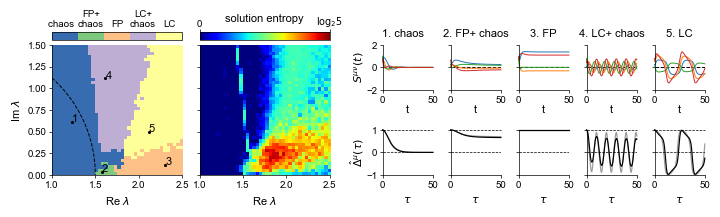

In [8]:
axes, cax_1, cax_2 = make_axes()
plot_main_heatmap(axes[0], cax_1)
plot_ent_heatmap(axes[1], cax_2)
plot_examples(axes[2:])
axes[2].set_ylabel("$S^{\mu\\nu}(t)$", labelpad=0)
axes[3].set_ylabel("$\hat{\Delta}^{\mu}(\\tau)$", labelpad=0)

#plt.savefig('../figs/heatmaps.pdf', dpi=450)